# **Competición Redes Neuronales**

### **Instalación de dependencias**

In [53]:
# pip install numpy matplotlib torch scikit-learn pandas

### **Importar librerías**

In [54]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [55]:
semilla = 42
np.random.seed(semilla)
torch.manual_seed(semilla)
torch.cuda.manual_seed_all(semilla)
random.seed(semilla)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### **Carga y lectura de datos de entrenamiento**

#### Al presentar un formato de archivo NPZ, contenedor comprimido que almacena arrglos de NumPy, es necesario ver cuantos archivos existen por medio de sus claves de identificación

In [56]:
x = np.load('/Users/miguelflores/Desktop/Redes-Neuronales/data/X_train.npz')
y = np.load('/Users/miguelflores/Desktop/Redes-Neuronales/data/Y_train.npz')
print(x)
print(y)

NpzFile '/Users/miguelflores/Desktop/Redes-Neuronales/data/X_train.npz' with keys: X_tr
NpzFile '/Users/miguelflores/Desktop/Redes-Neuronales/data/Y_train.npz' with keys: Y_tr


In [57]:
# Visualizar las claves
print('Clave de x_train:', x.files,'Clave de y_train:',  y.files)

Clave de x_train: ['X_tr'] Clave de y_train: ['Y_tr']


### **Dimensión**

In [58]:
x = x['X_tr']
y = y['Y_tr']
x.shape, y.shape

((35000, 784), (35000,))

#### En 'x', presentamos 35,000 observaciones con 784 características, las cuales son provenientes del aplanado de imagenes con dimensiones (28x28). En 'y' son las etiquetas que estan asociadas a cada una de las observaciones de x_train.

### **Tipo de datos**

In [59]:
x.dtype, y.dtype

(dtype('float32'), dtype('int64'))

#### Rectificamos el tipo de datos para cada archivo, donde las imágenes deben ser de tipo float, ya que esto permite calcular gradientes y realizar predicciones. Además, se representan como matrices de píxeles que pueden tener valores entre 0 y 255 (escala de grises) o entre 0 y 1 cuando están normalizadas. Las etiquetas deben ser de tipo entero, ya que representan clases, lo que facilita la estimación de las funciones de coste.

### **Contenido de las variables**

In [60]:
# Imagenes
minimo = np.min(x)
maximo = np.max(x)
print(f'Valores de las imagenes:')
print(f'Mínimo: {minimo}, Máximo: {maximo}')

Valores de las imagenes:
Mínimo: 0.0, Máximo: 0.99609375


In [61]:
# Etiquetas
numero_clases = len(np.unique(y))
print(f"El número de clases en el dataset es: {numero_clases}")
np.unique(y)


El número de clases en el dataset es: 2


array([0, 1])

#### Determinamos que las imágenes ya están normalizadas, ya que presentan valores entre 0 y 1. Por lo tanto, no es necesario dividirlas entre 255 (valor máximo en escala de grises). Además, las etiquetas representan dos clases, lo que confirma que se trata de un problema de clasificación binaria.

# **Inicialización**

### **Preparación de datos: División en entrenamiento y validación**

In [62]:
porcentaje_train = 0.1  #10% de validacion

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = porcentaje_train, random_state = semilla)

#### *Rectificamos división*

In [63]:
# Verificar las dimensiones
print(f"X_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")

X_train shape: (31500, 784), y_train shape: (31500,)
X_valid shape: (3500, 784), y_valid shape: (3500,)


### **Cambio de formato**

#### Al corroborar la división en entrenamiento y validación de ambas bases de datos, es posible visualizar que las imagenes siguen presentando un formato aplanado, por lo que para ser apatas para emplearse en una red neuronal convolucional, es necesario sustituirlas a una dimensión donde se presente el número de imagenes por lote, el canal de la imagen, la altura y el ancho. (N,C,H,W).

In [64]:
# Reformatear x_train y x_valid
x_train = torch.from_numpy(x_train).view(-1, 1, 28, 28).to('mps')  # (N, 1, 28, 28)
x_valid = torch.from_numpy(x_valid).view(-1, 1, 28, 28).to('mps')  # (N, 1, 28, 28)

#### Inicialmente presentamos el número de imagenes por lote (-1), donde se situa un valor negativo debido a que nos ayuda a determinar de manera automática el tamaño del lote con base en el número total de elementos del tensor. Después se presenta la dimensión de las imágenes, siendo de 28 x 28, lo cual significa que la imagen es una matriz bidimensional en la que cada entrada representa la intensidad de un píxel. Esto implica que, al haber un solo valor por píxel, la imagen es en escala de grises (1 canal), ya que cada píxel tiene un único valor que define su intensidad (brillo u oscuridad). Además, no hay información adicional de color ni transparencia.

### **Especificamos parámetros de la red**

In [65]:
epoch = 15
batch = 32
aprendizaje = [0.001, 0.01, 0.1]
momentums = [0.8, 0.9, 0.99]

### **TensorDate**

In [66]:
tensor_train = TensorDataset(x_train, torch.from_numpy(y_train).to('mps'))
tensor_valid = TensorDataset(x_valid, torch.from_numpy(y_valid).to('mps'))

### **Dataloaders**

In [67]:
train_loader = DataLoader(tensor_train, batch_size = batch, shuffle=True)  # Para entrenamiento
valid_loader = DataLoader(tensor_valid, batch_size = batch, shuffle=False)  # Para validación

### **Pesos**

In [68]:
w1 = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / (3 * 3 * 1)), (32, 1, 3, 3)).astype('float32')).to('mps').requires_grad_()
w2 = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / (3 * 3 * 32)), (64, 32, 3, 3)).astype('float32')).to('mps').requires_grad_()
w_dense = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / 36864), (36864, 1)).astype('float32')).to('mps').requires_grad_()

### **Sesgos**

In [69]:
b1 = torch.zeros((32,), dtype=torch.float32).to('mps').requires_grad_()
b2 = torch.zeros((64,), dtype=torch.float32).to('mps').requires_grad_()
b_dense = torch.zeros((1,), dtype=torch.float32).to('mps').requires_grad_()

### **Parametros**

In [70]:
parametros = [w1, b1, w2, b2, w_dense, b_dense]

# **Forward**

### **Funciones**

In [71]:
# Funcion de activación
def activation(x, func):
    if func == "relu":
        return F.relu(x)
    elif func == "sigmoid":
        return torch.sigmoid(x)
    else:
        raise ValueError("Función de activación no soportada")

# Función de propagación hacia adelante
def forward(x):
    # Primera convolución
    x = F.conv2d(x, w1, b1, stride=1, padding=0)
    x = activation(x, 'relu')
    # Segunda convolución
    x = F.conv2d(x, w2, b2, stride=1, padding=0)
    x = activation(x, 'relu')
    # Flatten
    x = x.view(x.size(0), -1)  # Aplanar a (batch_size, 36864)
    # Capa densa
    logits = x @ w_dense + b_dense
    return logits

# Función de pérdida
def perdida(y_pred, y_true):
    # Asegurar que y_true tenga la misma forma que y_pred
    y_true = y_true.unsqueeze(-1)  # Convertir de (32) a (32, 1)
    return F.binary_cross_entropy_with_logits(y_pred, y_true.float())

# Función de calculo de precisión
def precision(y_pred, y_true):
    y_true = y_true.unsqueeze(-1)  # Asegurar que las dimensiones coincidan
    predictions = (torch.sigmoid(y_pred) > 0.5).int()  # Convertir logits a etiquetas binarias
    accuracy = (predictions == y_true).float().mean().item()  # Comparar y calcular promedio
    return accuracy

In [72]:
# Probabilidad de dropout
p_dropout = 0.5

# Función de activación
def activation(x, func):
    if func == "relu":
        return F.relu(x)
    elif func == "sigmoid":
        return torch.sigmoid(x)
    else:
        raise ValueError("Función de activación no soportada")

# Función de propagación hacia adelante
def forward(x, training=True):
    """
    Propagación hacia adelante con Dropout.
    Args:
        x (torch.Tensor): Entrada.
        training (bool): Si es True, se aplica Dropout.
    Returns:
        logits (torch.Tensor): Salida del modelo.
    """
    # Primera convolución con activación y Dropout
    x = F.conv2d(x, w1, b1, stride=1, padding=0)
    x = activation(x, 'relu')
    if training:
        x = F.dropout(x, p = p_dropout, training=training)

    # Segunda convolución con activación y Dropout
    x = F.conv2d(x, w2, b2, stride=1, padding=0)
    x = activation(x, 'relu')
    if training:
        x = F.dropout(x, p = p_dropout, training=training)

    # Flatten
    x = x.view(x.size(0), -1)  # Aplanar a (batch_size, 36864)

    # Capa densa con Dropout
    x = F.dropout(x, p = p_dropout, training=training)
    logits = x @ w_dense + b_dense

    return logits

# Función de pérdida
def perdida(y_pred, y_true):
    # Asegurar que y_true tenga la misma forma que y_pred
    y_true = y_true.unsqueeze(-1)  # Convertir de (32) a (32, 1)
    return F.binary_cross_entropy_with_logits(y_pred, y_true.float())

# Función de cálculo de precisión
def precision(y_pred, y_true):
    y_true = y_true.unsqueeze(-1)  # Asegurar que las dimensiones coincidan
    predictions = (torch.sigmoid(y_pred) > 0.5).int()  # Convertir logits a etiquetas binarias
    accuracy = (predictions == y_true).float().mean().item()  # Comparar y calcular promedio
    return accuracy

### **Bucle de Entrenamiento**

In [73]:
# Parámetros para Early Stopping
iteracion_sin_mejora = 3  # Número de épocas sin mejora permitidas

# Variables para almacenar el mejor resultado global
best_hyperparameters = None
best_validation_accuracy_global = 0.0

# Diccionario para almacenar los resultados
results = []

# Loop para probar combinaciones de learning_rate y momentum
for lr in aprendizaje:
    for mm in momentums:
        print(f"\n------- Probando combinación: learning_rate={lr}, momentum={mm} -------")

        # Configurar optimizador con los valores actuales
        optimizer = torch.optim.SGD(parametros, lr=lr, momentum=mm)

        # Reiniciar métricas y variables
        train_losses = []
        train_accuracies = []
        valid_losses = []
        valid_accuracies = []
        best_validation_accuracy = 0.0
        epochs_without_improvement = 0

        # Entrenamiento con Early Stopping
        for epoch in range(epoch):
            ce = 0.0  # Pérdida acumulada
            acc = 0.0  # Precisión acumulada

            # Entrenamiento por lotes
            for x_batch, y_batch in train_loader:
                y_pred = forward(x_batch, training=True)  # Activar Dropout
                loss = perdida(y_pred, y_batch)  # Pérdida
                accuracy = precision(y_pred, y_batch)  # Precisión del mini-lote

                # Gradientes y optimización
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                ce += loss.item()
                acc += accuracy

            # Guardar métricas de entrenamiento
            train_losses.append(ce / len(train_loader))
            train_accuracies.append(acc / len(train_loader))

            # Evaluación en el conjunto de validación
            test_loss = 0.0
            test_acc = 0.0
            for x_test, y_test in valid_loader:
                y_pred = forward(x_test, training=False)  # Desactivar Dropout
                test_loss += perdida(y_pred, y_test).item()
                test_acc += precision(y_pred, y_test)

            # Guardar métricas de validación
            valid_losses.append(test_loss / len(valid_loader))
            valid_accuracies.append(test_acc / len(valid_loader))

            # Guardar resultados en el diccionario
            results.append({
                "learning_rate": lr,
                "momentum": mm,
                "epoch": epoch + 1,
                "train_loss": train_losses[-1],
                "train_accuracy": train_accuracies[-1],
                "valid_loss": valid_losses[-1],
                "valid_accuracy": valid_accuracies[-1]
            })

            # Resultados
            print(f"[learning_rate={lr}, momentum={mm}] Epoch {epoch + 1}/{epoch}, "
                  f"Train Loss: {ce / len(train_loader):.4f}, "
                  f"Train Accuracy: {acc / len(train_loader) * 100:.2f}%, "
                  f"Validation Loss: {test_loss / len(valid_loader):.4f}, "
                  f"Validation Accuracy: {test_acc / len(valid_loader) * 100:.2f}%")

            # Early Stopping: verificar si hay mejora en la precisión de validación
            if test_acc / len(valid_loader) > best_validation_accuracy:
                best_validation_accuracy = test_acc / len(valid_loader)
                epochs_without_improvement = 0  # Reiniciar contador si hay mejora
                print(f"*** Mejor precisión de validación encontrada: {best_validation_accuracy * 100:.2f}% ***")
            else:
                epochs_without_improvement += 1
                print(f"No hubo mejora en la precisión de validación. "
                      f"Épocas sin mejora: {epochs_without_improvement}/{iteracion_sin_mejora}")

            # Detener el entrenamiento si no hay mejora por `iteracion_sin_mejora` épocas consecutivas
            if epochs_without_improvement >= iteracion_sin_mejora:
                print(f"*** Early stopping activado. Mejor precisión de validación: {best_validation_accuracy * 100:.2f}% ***")
                break

        # Comparar el mejor resultado con el global
        if best_validation_accuracy > best_validation_accuracy_global:
            best_validation_accuracy_global = best_validation_accuracy
            best_hyperparameters = (lr, mm)

# Guardar los resultados en el diccionario
print("\nResultados almacenados.")

# Resultado final
if best_hyperparameters:
    print(f"\n------- Mejor combinación encontrada -------")
    print(f"Learning Rate: {best_hyperparameters[0]}, Momentum: {best_hyperparameters[1]}, "
          f"Validation Accuracy: {best_validation_accuracy_global * 100:.2f}%")
else:
    print("\nNo se encontró ninguna combinación con mejora.")


------- Probando combinación: learning_rate=0.001, momentum=0.8 -------
[learning_rate=0.001, momentum=0.8] Epoch 1/0, Train Loss: 0.3666, Train Accuracy: 84.50%, Validation Loss: 0.2555, Validation Accuracy: 92.47%
*** Mejor precisión de validación encontrada: 92.47% ***
[learning_rate=0.001, momentum=0.8] Epoch 2/1, Train Loss: 0.2484, Train Accuracy: 89.75%, Validation Loss: 0.2169, Validation Accuracy: 92.56%
*** Mejor precisión de validación encontrada: 92.56% ***
[learning_rate=0.001, momentum=0.8] Epoch 3/2, Train Loss: 0.2016, Train Accuracy: 91.97%, Validation Loss: 0.1823, Validation Accuracy: 94.38%
*** Mejor precisión de validación encontrada: 94.38% ***
[learning_rate=0.001, momentum=0.8] Epoch 4/3, Train Loss: 0.1768, Train Accuracy: 93.13%, Validation Loss: 0.1658, Validation Accuracy: 95.09%
*** Mejor precisión de validación encontrada: 95.09% ***
[learning_rate=0.001, momentum=0.8] Epoch 5/4, Train Loss: 0.1593, Train Accuracy: 93.95%, Validation Loss: 0.1461, Validat

### **Gráficos**

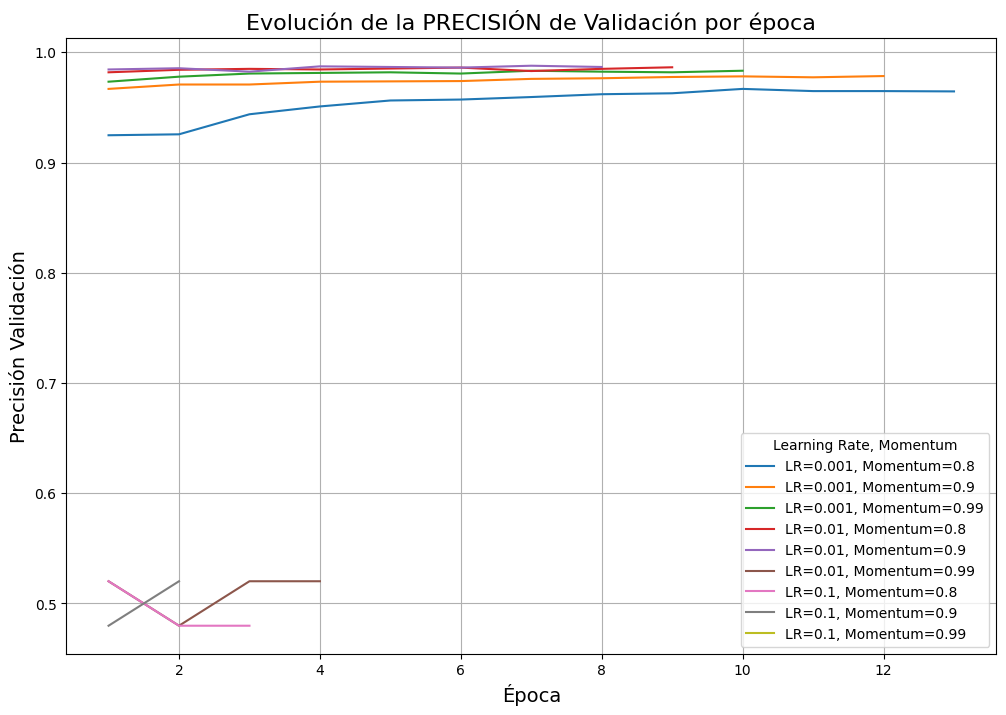

In [74]:
# Convertir los resultados en un DataFrame para facilitar el análisis
df = pd.DataFrame(results)

# Filtrar los datos para cada combinación de learning_rate y momentum
combinations = df.groupby(['learning_rate', 'momentum'])

# Graficar la evolución de "valid_accuracy" por epoch para cada combinación
plt.figure(figsize=(12, 8))
for (lr, mm), group in combinations:
    plt.plot(group['epoch'], group['valid_accuracy'], label=f'LR={lr}, Momentum={mm}')

plt.title('Evolución de la PRECISIÓN de Validación por época', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Precisión Validación', fontsize=14)
plt.legend(title="Learning Rate, Momentum", fontsize=10)
plt.grid(True)
plt.show()


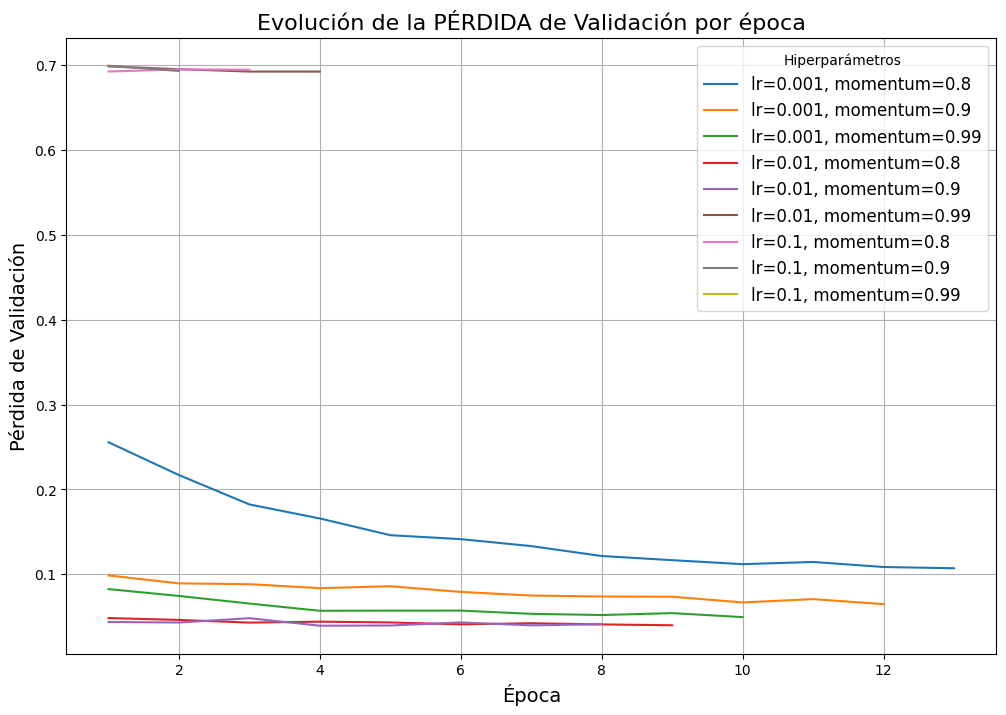

In [75]:
# Configurar el gráfico de evolución de la pérdida de validación
plt.figure(figsize=(12, 8))

# Generar el gráfico
for (lr, mm), data in df.groupby(['learning_rate', 'momentum']):
    plt.plot(data['epoch'], data['valid_loss'], label=f"lr={lr}, momentum={mm}")

# Configurar etiquetas y título
plt.title('Evolución de la PÉRDIDA de Validación por época', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Pérdida de Validación', fontsize=14)
plt.legend(title='Hiperparámetros', fontsize=12)
plt.grid(True)

# Mostrar el gráfico
plt.show()

### **Función test**

In [76]:
# Función para guardar predicciones
def save_predictions(X_te):
    """
    Genera y guarda las predicciones en un archivo comprimido.

    Args:
        X_te: Conjunto de imágenes de prueba (torch.Tensor).
    """
    # Asegurar que X_te tiene la forma correcta
    X_te = X_te.view(-1, 1, 28, 28).to('mps')  # Ajustar forma si es necesario
    with torch.no_grad():
        # Forward para generar predicciones
        logits = forward(X_te)  # Pasar las imágenes por el modelo
        probabilities = torch.sigmoid(logits)  # Convertir logits a probabilidades
        Y_te = (probabilities > 0.5).int().cpu().numpy().flatten()  # Convertir a etiquetas binarias (0 o 1)

    # Guardar predicciones en un archivo comprimido
    np.savez_compressed('Y_test', Y_te=Y_te)
    print("Predicciones guardadas en 'Y_test.npz'.")